# InfoGAN Tutorial

This tutorials walks through an implementation of InfoGAN as described in [InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets](https://arxiv.org/abs/1606.03657).

To learn more about InfoGAN, see this [Medium post](https://medium.com/p/dd710852db46) on them. To lean more about GANs generally, see [this one](https://medium.com/@awjuliani/generative-adversarial-networks-explained-with-a-classic-spongebob-squarepants-episode-54deab2fce39#.692jyamki).

In [1]:
#Import the libraries we will need.
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim
import os
import scipy.misc
import scipy
import gzip
import pickle
import time

In [2]:
np_rng = np.random.RandomState(42)

### Helper Functions

In [3]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)
    
#The below functions are taken from carpdem20's implementation https://github.com/carpedm20/DCGAN-tensorflow
#They allow for saving sample images from the generator to follow progress
def save_images(images, size, image_path):
    return imsave(inverse_transform(images), size, image_path)

def imsave(images, size, path):
    return scipy.misc.imsave(path, merge(images, size))

def inverse_transform(images):
    return (images+1.)/2.

def merge(images, size):
    h, w = images.shape[1], images.shape[2]
    img = np.zeros((h * size[0], w * size[1]))

    for idx, image in enumerate(images):
        i = idx % size[1]
        j = idx // size[1]
        img[j*h:j*h+h, i*w:i*w+w] = image

    return img

def load_mnist(dataset="training", digits=np.arange(10), path="data"):
    if dataset == "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset == "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = np.zeros((N, rows, cols), dtype=np.uint8)
    labels = np.zeros((N, 1), dtype=np.int8)
    for i in range(len(ind)):
        images[i] = np.array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((rows, cols))
        labels[i] = lbl[ind[i]]

    return images, labels


def gray_plot(im,d=1,d1=1,new_figure=True):
    if new_figure:
        plt.figure(figsize=[d,d1])
    plt.imshow(im,interpolation='None',cmap='Greys')
    
def show_examples(x,square=True,h=28,w=28):
    N = x.shape[0]
    if square:
        d = int(np.ceil(np.sqrt(N)))
        d1 = int(np.ceil(N/d))
    else:
        d = N
        d1 = 1
        
    im = np.ones([1+d1*(h+1),1+d*(w+1)])
    for i in range(d1):
        for j in range(d):
            c = i*d + j
            if c<N:
                im[1+i*(h+1):(i+1)*(h+1),1+j*(w+1):(j+1)*(w+1)] = x[c,:].reshape([h,w])
    gray_plot(im,d,d1,True)

In [4]:
from sklearn import utils as skutils
def list_shuffle(*data):
    idxs = np_rng.permutation(np.arange(len(data[0])))
    if len(data) == 1:
        return [data[0][idx] for idx in idxs]
    else:
        return [[d[idx] for idx in idxs] for d in data]

def shuffle(*arrays, **options):
    if isinstance(arrays[0][0], str):
        return list_shuffle(*arrays)
    else:
        return skutils.shuffle(*arrays, random_state=np_rng)

### Load Data

Load the MNIST dataset.

In [5]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=False)
faces = np.load('/home/charles/Documents/code/Tensorflow/Data/FreyFaces/freyfaces.npy',encoding='latin1')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
#Load Snapshot Data
fp = gzip.open('../Data/ChannelizedMedia/OptSnapshots.pkl.gz')
images = pickle.load(fp)
fp.close()
images = images[:,:2025]

#resize
h=w=45
images = np.reshape(images, [images.shape[0],h,w])

#add data with swapped axis order (x, y, xy)
images2 = images[:, ::-1, ::]
images3 = images[:, ::, ::-1]
images4 = images[:, ::-1, ::-1]
images = np.concatenate((images,images2,images3,images4))


# #add data with swapped axes (up-down)
# images2 = np.swapaxes(images,1,2)
# images = np.concatenate((images,images2))

#truncate  
image_dim = h = w = 32
data_x = images[:,:h,:w,None]
print("Data shape: ",data_x.shape)
print("Original Data min, max:", data_x.min(), data_x.max() )

#transform
data_x = data_x - data_x.min()
data_x = data_x / data_x.max()
print("Scaled, Shifted Data min, max:", data_x.min(), data_x.max() )

# #log-transform
# data_x = np.exp(data_x)
# print("Log-Transformed, Scaled, Shifted Data min, max:", data_x.min(), data_x.max() )

#center
# data_x = (data_x - np.mean(data_x,axis=0))*2
data_x = (data_x - 0.5)*2
print("Centered, Log-Transformed, Scaled, Shifted Data min, max:", data_x.min(), data_x.max() )
print("Data shape: ", data_x.shape)


Data shape:  (4000, 32, 32, 1)
Original Data min, max: 10.0 1000.0
Scaled, Shifted Data min, max: 0.0 1.0
Centered, Log-Transformed, Scaled, Shifted Data min, max: -1.0 1.0
Data shape:  (4000, 32, 32, 1)


In [7]:
#shuffle the order of the data
nshuffles = 100
for i in range(nshuffles):
    data_x = shuffle(data_x)

In [8]:
# def fully_connected(inputs,
#                     num_outputs,
#                     activation_fn=nn.relu,
#                     normalizer_fn=None,
#                     normalizer_params=None,
#                     weights_initializer=initializers.xavier_initializer(),
#                     weights_regularizer=None,
#                     biases_initializer=init_ops.zeros_initializer(),
#                     biases_regularizer=None,
#                     reuse=None,
#                     variables_collections=None,
#                     outputs_collections=None,
#                     trainable=True,
#                     scope=None):

def sampler(m,s):
    eps = tf.truncated_normal(m.shape)
    return m + eps * s

def encoder(x):

    h_enc_1 = slim.fully_connected(x,
                                  num_hidden,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=tf.nn.relu,
                                  scope='h_enc_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
#     h_enc_1.set_shape([None,num_hidden])
#     print(h_enc_1.get_shape())
#     h_enc_2 = slim.conv2d(h_enc1,
#                                   num_hidden,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=tf.nn.relu,
#                                   scope='h_enc_2',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = slim.l1_regularizer(1e-6))
    
    mu_enc_1 = slim.fully_connected(h_enc_1,
                                  dim_latent,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None, #tf.nn.legacy_linear,
                                  scope='mu_enc_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
#     mu_enc_1.set_shape([None,dim_latent])
    
    logsigma2_enc_1 = slim.fully_connected(h_enc_1,
                                  dim_latent,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None,#tf.nn.linear,
                                  scope='logsigma2_enc_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
    
#     z = tf.truncated_normal(shape=[None, dim_latent], mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)
#     print(mu_enc_1.get_shape(), logsigma2_enc_1.get_shape(), z.get_shape())
    

    return mu_enc_1, logsigma2_enc_1

def decoder(z):
    h_dec_1 = slim.fully_connected(z,
                                  num_hidden,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=tf.nn.relu,
                                  scope='h_dec_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)

    mu_dec_1 = slim.fully_connected(h_dec_1,
                                  dim_real,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None,#tf.nn.linear,
                                  scope='mu_dec_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
    logsigma2_dec_1 = slim.fully_connected(h_dec_1,
                                  dim_real,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None,#tf.nn.linear,
                                  scope='logsigma2_dec_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
    

    print(mu_dec_1.get_shape(), logsigma2_dec_1.get_shape())
    return mu_dec_1, logsigma2_dec_1




                              
                              

In [9]:
# # def fully_connected(inputs,
# #                     num_outputs,
# #                     activation_fn=nn.relu,
# #                     normalizer_fn=None,
# #                     normalizer_params=None,
# #                     weights_initializer=initializers.xavier_initializer(),
# #                     weights_regularizer=None,
# #                     biases_initializer=init_ops.zeros_initializer(),
# #                     biases_regularizer=None,
# #                     reuse=None,
# #                     variables_collections=None,
# #                     outputs_collections=None,
# #                     trainable=True,
# #                     scope=None):

# def sampler(m,s):
#     eps = tf.truncated_normal(m.shape)
#     return m + eps * s

# def encoder(x, reuse=False):
#     # Input Layer
#     input_layer = tf.reshape(x, [-1, image_dim, image_dim, 1])    

#     dis1 = slim.convolution2d(input_layer,
#                               32,
#                               [3,3],
#                               padding="SAME",
#                               biases_initializer=None,
#                               activation_fn=lrelu,
#                               reuse=reuse,
#                               scope='d_conv1',
#                               weights_initializer=initializer
#                              )
#     dis1 = tf.space_to_depth(dis1,2)
    
#     dis2 = slim.convolution2d(dis1,64,[3,3],padding="SAME",\
#         normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
#         reuse=reuse,scope='d_conv2', weights_initializer=initializer)
#     dis2 = tf.space_to_depth(dis2,2)
    
#     dis3 = slim.convolution2d(dis2,128,[3,3],padding="SAME",\
#         normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
#         reuse=reuse,scope='d_conv3',weights_initializer=initializer)
#     dis3 = tf.space_to_depth(dis3,2)
        
#     dis4 = slim.fully_connected(slim.flatten(dis3),1024,activation_fn=lrelu,\
#         reuse=reuse,scope='d_fc1', weights_initializer=initializer)
        
#     h_enc_1 = slim.fully_connected(dis4,
#                                   num_hidden,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=tf.nn.tanh,
#                                   scope='h_enc_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)
    
#     mu_enc_1 = slim.fully_connected(h_enc_1,
#                                   dim_latent,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=None, #tf.nn.legacy_linear,
#                                   scope='mu_enc_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)
    
#     logsigma2_enc_1 = slim.fully_connected(h_enc_1,
#                                   dim_latent,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=None,#tf.nn.linear,
#                                   scope='logsigma2_enc_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)

#     print(mu_enc_1.get_shape(), logsigma2_enc_1.get_shape())
    
#     return mu_enc_1, logsigma2_enc_1

# def decoder(z):
#     # Input Layer
#     input_layer = z#tf.reshape(z, [-1, latent_image_dim, latent_image_dim, 1])   
#     print(input_layer.get_shape())
    
#     zP = slim.fully_connected( input_layer ,4*4*1,normalizer_fn=slim.batch_norm,\
#         activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
#     print(zP.get_shape())
    
#     zCon = tf.reshape(zP,[-1,4,4,1])
#     print(zCon.get_shape())

#     gen1 = slim.convolution2d(\
#         zCon,num_outputs=128,kernel_size=[3,3],\
#         padding="SAME",normalizer_fn=slim.batch_norm,\
#         activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
#     gen1 = tf.depth_to_space(gen1,2)
#     print(gen1.get_shape())

#     gen2 = slim.convolution2d(\
#         gen1,num_outputs=64,kernel_size=[3,3],\
#         padding="SAME",normalizer_fn=slim.batch_norm,\
#         activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
#     gen2 = tf.depth_to_space(gen2,2)
#     print(gen2.get_shape())

#     gen3 = slim.convolution2d(\
#         gen2,num_outputs=32,kernel_size=[3,3],\
#         padding="SAME",normalizer_fn=slim.batch_norm,\
#         activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
#     gen3 = tf.depth_to_space(gen3,2)
#     print("gen3 shape:", gen3.get_shape())

#     g_out = slim.convolution2d(gen3,
#                                num_outputs=1,
#                                kernel_size=[32,32],
# #                                kernel_size=[32,32],
#                                padding="SAME",\
#         biases_initializer=None,activation_fn=tf.nn.tanh,\
#         scope='g_out', weights_initializer=initializer)
#     print("g_out shape:", g_out.get_shape())
    
#     #reshape
#     g_in = tf.reshape( g_out , [-1, dim_real])
#     print("g_in shape:", g_in.get_shape())
    
#     h_dec_1 = slim.fully_connected(g_in,
#                                   num_hidden,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=tf.nn.relu,
#                                   scope='h_dec_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)

#     mu_dec_1 = slim.fully_connected(h_dec_1,
#                                   dim_real,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=None,#tf.nn.linear,
#                                   scope='mu_dec_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)
#     logsigma2_dec_1 = slim.fully_connected(h_dec_1,
#                                   dim_real,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=None,#tf.nn.linear,
#                                   scope='logsigma2_dec_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)
    

#     print(mu_dec_1.get_shape(), logsigma2_dec_1.get_shape())
#     return mu_dec_1, logsigma2_dec_1




                              
                              

In [10]:
# def fully_connected(inputs,
#                     num_outputs,
#                     activation_fn=nn.relu,
#                     normalizer_fn=None,
#                     normalizer_params=None,
#                     weights_initializer=initializers.xavier_initializer(),
#                     weights_regularizer=None,
#                     biases_initializer=init_ops.zeros_initializer(),
#                     biases_regularizer=None,
#                     reuse=None,
#                     variables_collections=None,
#                     outputs_collections=None,
#                     trainable=True,
#                     scope=None):

def sampler(m,s):
    eps = tf.truncated_normal(m.shape)
    return m + eps * s

def encoder(x, reuse=False):
    # Input Layer
    input_layer = tf.reshape(x, [-1, image_dim, image_dim, 1])    

    dis1 = slim.convolution2d(input_layer,
                              32,
                              [3,3],
                              padding="SAME",
                              biases_initializer=None,
                              activation_fn=lrelu,
                              reuse=reuse,
                              scope='d_conv1',
                              weights_initializer=initializer
                             )
    dis1 = tf.space_to_depth(dis1,2)
    
    dis2 = slim.convolution2d(dis1,64,[3,3],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv2', weights_initializer=initializer)
    dis2 = tf.space_to_depth(dis2,2)
    
    dis3 = slim.convolution2d(dis2,128,[3,3],padding="SAME",\
        normalizer_fn=slim.batch_norm,activation_fn=lrelu,\
        reuse=reuse,scope='d_conv3',weights_initializer=initializer)
    dis3 = tf.space_to_depth(dis3,2)
        
    h_enc_1 = slim.fully_connected(slim.flatten(dis3),num_hidden,activation_fn=tf.nn.tanh,\
        reuse=reuse,scope='d_fc1', weights_initializer=initializer)
        
#     h_enc_1 = slim.fully_connected(dis4,
#                                   num_hidden,
#                                   normalizer_fn=slim.batch_norm,
#                                   activation_fn=tf.nn.relu,
#                                   scope='h_enc_1',
#                                   weights_initializer=initializer,
#                                   weights_regularizer = weights_reg)
    
    mu_enc_1 = slim.fully_connected(h_enc_1,
                                  dim_latent,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None, #tf.nn.legacy_linear,
                                  scope='mu_enc_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
    
    logsigma2_enc_1 = slim.fully_connected(h_enc_1,
                                  dim_latent,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None,#tf.nn.linear,
                                  scope='logsigma2_enc_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)

    print(mu_enc_1.get_shape(), logsigma2_enc_1.get_shape())
    
    return mu_enc_1, logsigma2_enc_1

def decoder(z):
    # Input Layer
    input_layer = z#tf.reshape(z, [-1, latent_image_dim, latent_image_dim, 1])   
    print(input_layer.get_shape())
    
    zP = slim.fully_connected( input_layer ,4*4*1,normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_project',weights_initializer=initializer)
    print(zP.get_shape())
    
    zCon = tf.reshape(zP,[-1,4,4,1])
    print(zCon.get_shape())

    gen1 = slim.convolution2d(\
        zCon,num_outputs=128,kernel_size=[3,3],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv1', weights_initializer=initializer)
    gen1 = tf.depth_to_space(gen1,2)
    print(gen1.get_shape())

    gen2 = slim.convolution2d(\
        gen1,num_outputs=64,kernel_size=[3,3],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv2', weights_initializer=initializer)
    gen2 = tf.depth_to_space(gen2,2)
    print(gen2.get_shape())

    gen3 = slim.convolution2d(\
        gen2,num_outputs=32,kernel_size=[3,3],\
        padding="SAME",normalizer_fn=slim.batch_norm,\
        activation_fn=tf.nn.relu,scope='g_conv3', weights_initializer=initializer)
    gen3 = tf.depth_to_space(gen3,2)
    print("gen3 shape:", gen3.get_shape())

    g_out = slim.convolution2d(gen3,
                               num_outputs=1,
                               kernel_size=[32,32],
#                                kernel_size=[32,32],
                               padding="SAME",\
        biases_initializer=None,activation_fn=tf.nn.tanh,\
        scope='g_out', weights_initializer=initializer)
    print("g_out shape:", g_out.get_shape())
    
    #reshape
    g_in = tf.reshape( g_out , [-1, dim_real])
    print("g_in shape:", g_in.get_shape())
    
    h_dec_1 = slim.fully_connected(g_in,
                                  num_hidden,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=tf.nn.relu,
                                  scope='h_dec_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)

    mu_dec_1 = slim.fully_connected(h_dec_1,
                                  dim_real,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None,#tf.nn.linear,
                                  scope='mu_dec_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
    logsigma2_dec_1 = slim.fully_connected(h_dec_1,
                                  dim_real,
                                  normalizer_fn=slim.batch_norm,
                                  activation_fn=None,#tf.nn.linear,
                                  scope='logsigma2_dec_1',
                                  weights_initializer=initializer,
                                  weights_regularizer = weights_reg)
    

    print(mu_dec_1.get_shape(), logsigma2_dec_1.get_shape())
    return mu_dec_1, logsigma2_dec_1




                              
                              

In [11]:
tf.reset_default_graph()
weights_reg = None #slim.l1_regularizer(1e-6)
dim_real = image_dim*image_dim
latent_image_dim = 4
dim_latent = latent_image_dim*latent_image_dim
num_hidden = 1024#256
batch_size = 64

#This initializer is used to initialize all the weights of the network.
initializer = tf.truncated_normal_initializer(stddev=0.02)
# initializer = tf.orthogonal_initializer(
#     gain=1.0,
#     dtype=tf.float32,
#     seed=None
# )

#These placeholders are used for input into the generator and discriminator, respectively.
x = tf.placeholder(shape=[batch_size, dim_real], dtype=tf.float32) #Random vector
# mu_enc_1 = tf.placeholder(shape=[None , dim_latent],dtype=tf.float32) #Random vector
# logsigma2_enc_1 = tf.placeholder(shape=[None , dim_latent],dtype=tf.float32) #Random vector
# z = tf.placeholder(shape=[None , dim_latent],dtype=tf.float32) #Random vector

mu_enc_1, logsigma2_enc_1 = encoder(x)
# z = tf.truncated_normal(shape=[None, dim_latent], mean=0.0, stddev=1.0, dtype=tf.float32, seed=None, name=None)
z = sampler(mu_enc_1, logsigma2_enc_1)
print(z.get_shape())
mu_dec_1, logsigma2_dec_1 = decoder(z)

#These functions together define the optimization objective
logpxz = 0.5 * tf.reduce_sum(
    tf.log(2*np.pi) + logsigma2_dec_1 + 1.0*tf.exp(-logsigma2_dec_1 ) * tf.square(x - mu_dec_1),
    axis=1)

KLqzxpz = 0.5 * tf.reduce_sum( 
    1+ logsigma2_enc_1 - tf.square(mu_enc_1) - tf.exp( logsigma2_enc_1 ),
    axis=1)

#lower bound of logpx = tf.reduce_mean(logpxz - KLqzxpz)
loss = tf.reduce_mean(logpxz - KLqzxpz)


#Combine losses for each of the continous variables.
#...
tvars = tf.trainable_variables()

# #ADAM(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
#     )
trainer = tf.train.AdamOptimizer(learning_rate = 0.0002, beta1=0.1, beta2=0.001)
grads = trainer.compute_gradients(loss, tvars) 
                              
#compute updates
update = trainer.apply_gradients(grads)

(64, 16) (64, 16)
(64, 16)
(64, 16)
(64, 16)
(64, 4, 4, 1)
(64, 8, 8, 32)
(64, 16, 16, 16)
gen3 shape: (64, 32, 32, 8)
g_out shape: (64, 32, 32, 1)
g_in shape: (64, 1024)
(64, 1024) (64, 1024)


In [12]:
# batch_size = 64 #Size of image batch to apply at each iteration.
iterations = 50000#500000 #Total number of iterations to use.
sample_directory = './figs_VAE' #Directory to save sample images from generator in.
model_directory = './models_VAE' #Directory to save trained model to.

t0 = time.time()
init = tf.global_variables_initializer()
saver = tf.train.Saver()
vis_zbatch = np.random.uniform(-1.0,1.0,size=[batch_size, dim_latent]).astype(np.float32)
zi = np.linspace(-1,1,batch_size)
vis_zbatch = np.repeat(zi[:,None],dim_latent,axis=1).astype(np.float32)


with tf.Session() as sess:  
    sess.run(init)
    for i in range(iterations):
#         zs = np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent]).astype(np.float32) #Generate a random z batch

  
        idx_batch = np.arange(i*batch_size,(i+1)*batch_size) % data_x.shape[0]
        
# for mnist
#         xs,_ = mnist.train.next_batch(batch_size) #Draw a sample batch from MNIST dataset.
#         xs = (np.reshape(xs,[batch_size,28, 28,1]) - 0.5) * 2.0 #Transform it to be between -1 and 1
#         xs = np.lib.pad(xs, ((0,0),(2,2),(2,2),(0,0)),'constant', constant_values=(-1, -1)) #Pad the images so the are 32x32
#         xs = (np.reshape(xs,[batch_size,h*w]) - 0.5) * 2.0 #Transform it to be between -1 and 1
# for faces
#         xs = faces[idx_batch,:]
# other data
        xs = np.reshape( data_x[idx_batch, :, :], [-1, dim_real] ).astype(np.float32)

        _,iLoss = sess.run([update, loss ],feed_dict={x: xs}) 
        if i % 1000 == 0:
            tfinal = time.time()
            print("Iteration, Loss, time ", i,iLoss,tfinal-t0)
            zs = vis_zbatch#np.random.uniform(-1.0,1.0,size=[batch_size, dim_latent]).astype(np.float32)
            xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: zs})
            samples = xh_mu
            
            if not os.path.exists(sample_directory):
                os.makedirs(sample_directory)
            #Save sample generator images for viewing training progress.
            db = int(np.sqrt(batch_size))
            save_images(np.reshape(samples[0:batch_size],[batch_size,image_dim,image_dim]),[db,db],sample_directory+'/fig'+str(i)+'.png')
        if i % 1000 == 0 and i != 0:
            if not os.path.exists(model_directory):
                os.makedirs(model_directory)
            saver.save(sess,model_directory+'/model-'+str(i)+'.cptk')
            print( "Saved Model")

Iteration, Loss, time  0 2677.33 1.7632238864898682
Iteration, Loss, time  1000 986.328 15.0394287109375
Saved Model
Iteration, Loss, time  2000 876.557 29.08797550201416
Saved Model
Iteration, Loss, time  3000 795.321 42.84979319572449
Saved Model
Iteration, Loss, time  4000 688.148 56.59351873397827
Saved Model
Iteration, Loss, time  5000 613.265 70.41150760650635
Saved Model
Iteration, Loss, time  6000 526.726 84.27730941772461
Saved Model
Iteration, Loss, time  7000 457.207 98.50965523719788
Saved Model
Iteration, Loss, time  8000 393.731 112.75258731842041
Saved Model
Iteration, Loss, time  9000 319.207 127.086580991745
Saved Model
Iteration, Loss, time  10000 263.845 141.37470316886902
Saved Model
Iteration, Loss, time  11000 242.053 155.31924748420715
Saved Model
Iteration, Loss, time  12000 216.133 169.15970039367676
Saved Model
Iteration, Loss, time  13000 225.077 182.9590117931366
Saved Model
Iteration, Loss, time  14000 213.597 196.87228226661682
Saved Model
Iteration, Loss,

## Using a trained network
Once we have a trained model saved, we may want to use it to generate new images, and explore the representation it has learned.

In [25]:
import tensorflow as tf
sample_directory = './figs_VAE' #Directory to save sample images from generator in.
model_directory = './models_VAE' #Directory to load trained model from.

init = tf.initialize_all_variables()
saver = tf.train.Saver()
with tf.Session() as sess:  
    sess.run(init)
    #Reload the model.
    print('Loading Model...')
    ckpt = tf.train.get_checkpoint_state(model_directory)
    saver.restore(sess,ckpt.model_checkpoint_path)
    
    z_sample = np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent]).astype(np.float32) #Generate another z batch
    xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: z_sample})
    if not os.path.exists(sample_directory):
        os.makedirs(sample_directory)
    #Save sample generator images for viewing training progress.
    save_images(np.reshape(xh_mu[0:batch_size],[batch_size,32,32]),[latent_image_dim,latent_image_dim],sample_directory+'/fig_test_VAE'+'.png')

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Loading Model...


ValueError: could not broadcast input array from shape (32,32) into shape (0,32)

In [52]:
init = tf.initialize_all_variables()
saver = tf.train.Saver()
sess = tf.Session()
sess.run(init)
#Reload the model.
print('Loading Model...')
ckpt = tf.train.get_checkpoint_state(model_directory)
saver.restore(sess,ckpt.model_checkpoint_path)

z_sample = np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent]).astype(np.float32)
xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: z_sample})


Instructions for updating:
Use `tf.global_variables_initializer` instead.
Loading Model...


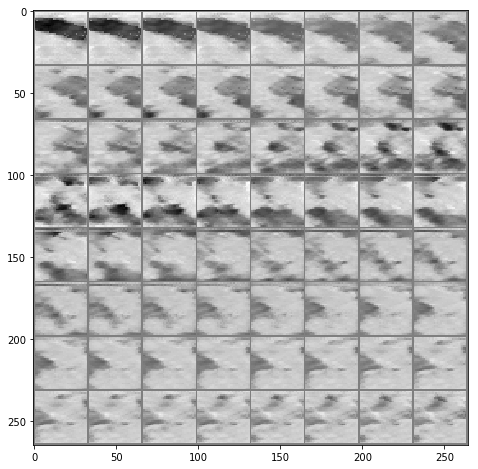

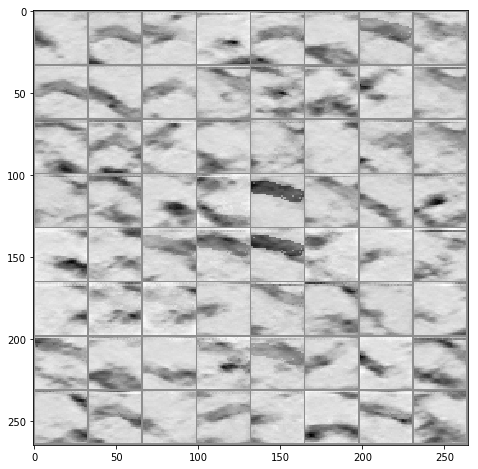

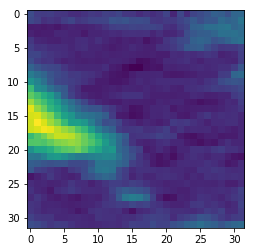

In [56]:
zi = np.linspace(-1,1,batch_size)
z_sample1 = np.repeat(zi[:,None],dim_latent,axis=1).astype(np.float32)
xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: z_sample1})
show_examples(xh_mu,h=32,w=32)
plt.show()

z_sample = np.random.uniform(-1.0,1.0,size=[batch_size,dim_latent]).astype(np.float32)
z_sample = np.sort(z_sample,axis=1)
xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: z_sample})
show_examples(xh_mu,h=32,w=32)
plt.show()

xs = np.reshape(xh_mu[0],[32,32])
xs2 = np.reshape(xh_sigma[0],[32,32])
xs2 = 0.5*np.exp( xs2 )
plt.imshow(xs+xs2)
plt.show()

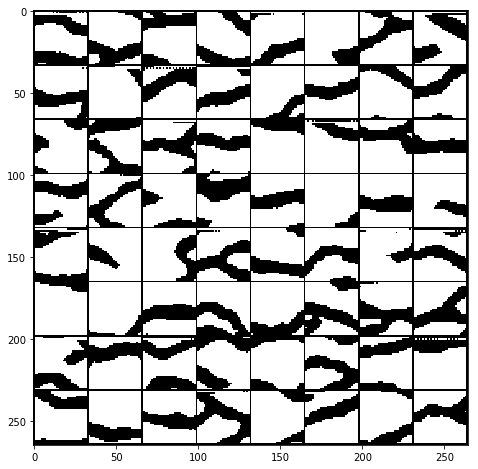

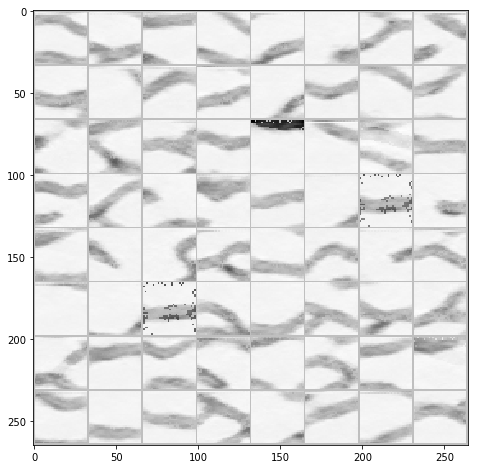

Relative Error: 0.414557


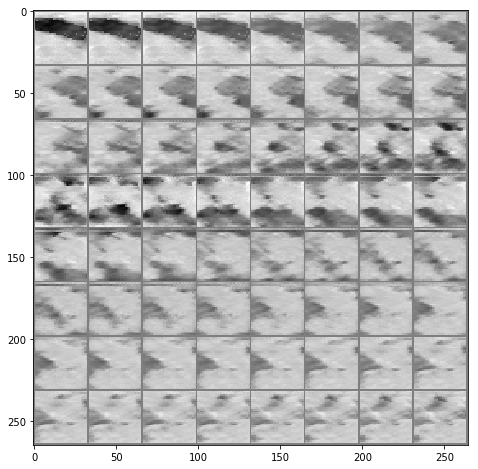

In [81]:
i=0
idx_batch = np.arange(i*batch_size,(i+1)*batch_size) % data_x.shape[0]
x_sample = np.reshape( data_x[idx_batch, :, :], [-1, dim_real] ).astype(np.float32)

zh_mu, zh_sigma = sess.run([mu_enc_1, logsigma2_enc_1 ],feed_dict={x: x_sample})
xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: zh_mu})
# xh_mu = (xh_mu/2 + 0.5)*1000

show_examples(x_sample,h=32,w=32)
plt.show()
show_examples(xh_mu,h=32,w=32)
plt.show()
print("Relative Error:", np.linalg.norm(xh_mu-x_sample,2)/np.linalg.norm(x_sample,2))
zi = np.linspace(-1,1,batch_size)
z_sample1 = np.repeat(zi[:,None],dim_latent,axis=1).astype(np.float32)
xh_mu, xh_sigma = sess.run([mu_dec_1, logsigma2_dec_1 ],feed_dict={z: z_sample1})
show_examples(xh_mu,h=32,w=32)
plt.show()


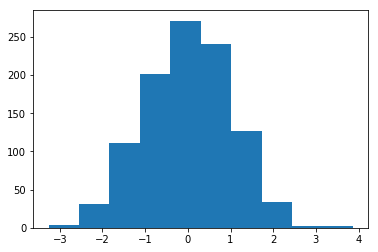

In [65]:
plt.hist(zh_mu.ravel())
plt.show()